In [1]:
import os
import sys
from pathlib import Path
parent_dir = str(Path().resolve().parent)
sys.path.append(parent_dir)
os.chdir(parent_dir)
import configs
import hybrid_autoencoder
import data_handler
import train
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
import re
SEED = 7

## Create synthetic dataset

Same dataset as presented in "4.1.4 CelebA: gender classification with known confounding" in this project's report

In [29]:
# In case of re-start, run this cell
prop = 0.95
n = 1808
train_ds, _, _, img_dir = data_handler.load_original_celebA()

men_with_glasses = train_ds[(train_ds['Male'] == 1) & (train_ds['Eyeglasses'] == 1)].groupby('ID').sample(n=1, random_state=SEED)
men_without_glasses = train_ds[(train_ds['Male'] == 1) & (train_ds['Eyeglasses'] == 0)].groupby('ID').sample(n=1, random_state=SEED)
women_with_glasses = train_ds[(train_ds['Male'] == 0) & (train_ds['Eyeglasses'] == 1)].groupby('ID').sample(n=1, random_state=SEED)
women_without_glasses = train_ds[(train_ds['Male'] == 0) & (train_ds['Eyeglasses'] == 0)].groupby('ID').sample(n=1, random_state=SEED)

mg = men_with_glasses.sample(n,random_state=SEED)
mwg = men_without_glasses[men_without_glasses['ID'].isin(mg['ID'])].sample(int((1-prop)*n), random_state=SEED) 
wwg = women_without_glasses.sample(n,random_state=SEED)
wg =   women_with_glasses[women_with_glasses['ID'].isin(wwg['ID'])].sample(int((1-prop)*n), random_state=SEED)
train_ds = pd.concat([mg, mwg, wwg, wg])

config = configs.celebA_experiment()
# ignore first two arguments
_, test1_ds, test2_ds, img_dir = data_handler.load_datasets_celebA_counfound(0.95, 10_000, config.test_size)

len(men_with_glasses), len(men_without_glasses), len(women_with_glasses), len(women_without_glasses)

print("Train set size: ", len(train_ds))
id_counts = train_ds['ID'].value_counts()
print("Distinct IDs that occur more than once: ", id_counts[id_counts > 1].count())
print("Mean occurrences of IDs: ", id_counts.mean())
print("Max occurrences of IDs: ", id_counts.max())

cross_tab = pd.crosstab(index=train_ds['Male'], columns=train_ds['Eyeglasses'])

cross_tab_percentage = cross_tab.div(cross_tab.sum().sum()) * 100

print("\n\nPercentage of images for each combination of gender and eyeglasses status:")
print(cross_tab_percentage)

grouped = train_ds.groupby(['ID', 'Eyeglasses']).size().unstack(fill_value=0)
ids_with_and_without_glasses = grouped[(grouped[0] > 0) & (grouped[1] > 0)]
distinct_ids_count = len(ids_with_and_without_glasses)
print("\n\nNumber of distinct IDs with at least one instance of eyeglasses being worn and not worn:", distinct_ids_count)
print("These IDs encompass a total of", ids_with_and_without_glasses.sum().sum(), "images")
print("Mean number of images with glasses per ID:", ids_with_and_without_glasses[1].mean())
print("Mean number of images without glasses per ID:", ids_with_and_without_glasses[0].mean())

Train set size:  3796
Distinct IDs that occur more than once:  236
Mean occurrences of IDs:  1.0689946493945368
Max occurrences of IDs:  4


Percentage of images for each combination of gender and eyeglasses status:
Eyeglasses          0          1
Male                            
0           47.629083   2.370917
1            2.370917  47.629083


Number of distinct IDs with at least one instance of eyeglasses being worn and not worn: 236
These IDs encompass a total of 481 images
Mean number of images with glasses per ID: 1.0254237288135593
Mean number of images without glasses per ID: 1.0127118644067796


In [3]:
# We train autoencoder on the entire dataset
train_synth = data_handler.conv_celebA_to_jax(pd.concat([train_ds, test1_ds, test2_ds], ignore_index=True), img_dir)

In [4]:
# Train contrastive autoencoder
config = configs.autoencoder_contrastive()
config.num_epochs = 50
config.learning_rate = 1e-3
config.lambda_reconstruction = 100.0
config.margin = 1_000_000.0  # for gender
config.lambda_gender = 1.0
config.lambda_id = 1.0  # margin hard-coded to 100.0
state_triplet = hybrid_autoencoder.train_and_evaluate(config, workdir=f"results/hybridAE", train_ds=train_synth)

INFO:absl:epoch: 1, train_loss: 1000106.1875, reconstruction loss: 0.0865, gender loss: 999992.5625, id loss: 104.9251, gender anchors: 81.1429, id anchors: 11.0571
INFO:absl:epoch: 2, train_loss: 948002.5625, reconstruction loss: 0.0828, gender loss: 908370.7500, id loss: 39623.5938, gender anchors: 80.3429, id anchors: 10.6000
INFO:absl:epoch: 3, train_loss: 803627.1250, reconstruction loss: 0.0817, gender loss: 726838.8125, id loss: 76780.1328, gender anchors: 81.2571, id anchors: 10.6000
INFO:absl:epoch: 4, train_loss: 626779.6875, reconstruction loss: 0.0815, gender loss: 539981.0000, id loss: 86790.6250, gender anchors: 80.8000, id anchors: 10.8571
INFO:absl:epoch: 5, train_loss: 558882.6250, reconstruction loss: 0.0813, gender loss: 461864.6562, id loss: 97009.8438, gender anchors: 79.8286, id anchors: 10.7143
INFO:absl:epoch: 6, train_loss: 489542.0625, reconstruction loss: 0.0810, gender loss: 421456.0000, id loss: 68077.9609, gender anchors: 79.5429, id anchors: 10.6571
INFO:

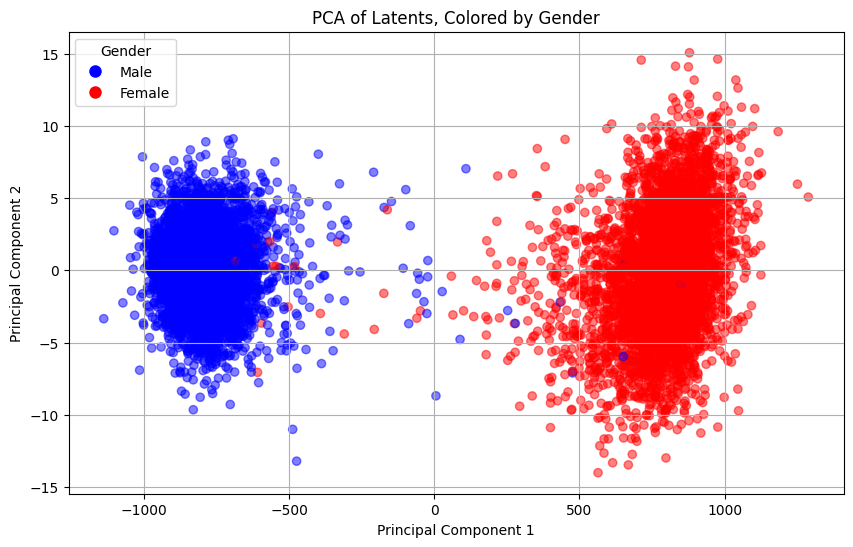

In [5]:
model = hybrid_autoencoder.AutoEncoder()
encoded_images = state_triplet.apply_fn({'params': state_triplet.params}, train_synth['image'], method=model.encode)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(encoded_images)

colors = ['blue' if label == 0 else 'red' for label in train_synth['label']]

plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, alpha=0.5)
plt.title('PCA of Latents, Colored by Gender')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Male'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Female')],
           title="Gender")
plt.grid(True)
plt.show()

In [30]:
# In case of re-start, run this cell
train_ds = data_handler.conv_celebA_to_jax(train_ds, img_dir)
test1_ds = data_handler.conv_celebA_to_jax(test1_ds, img_dir)
test2_ds = data_handler.conv_celebA_to_jax(test2_ds, img_dir)

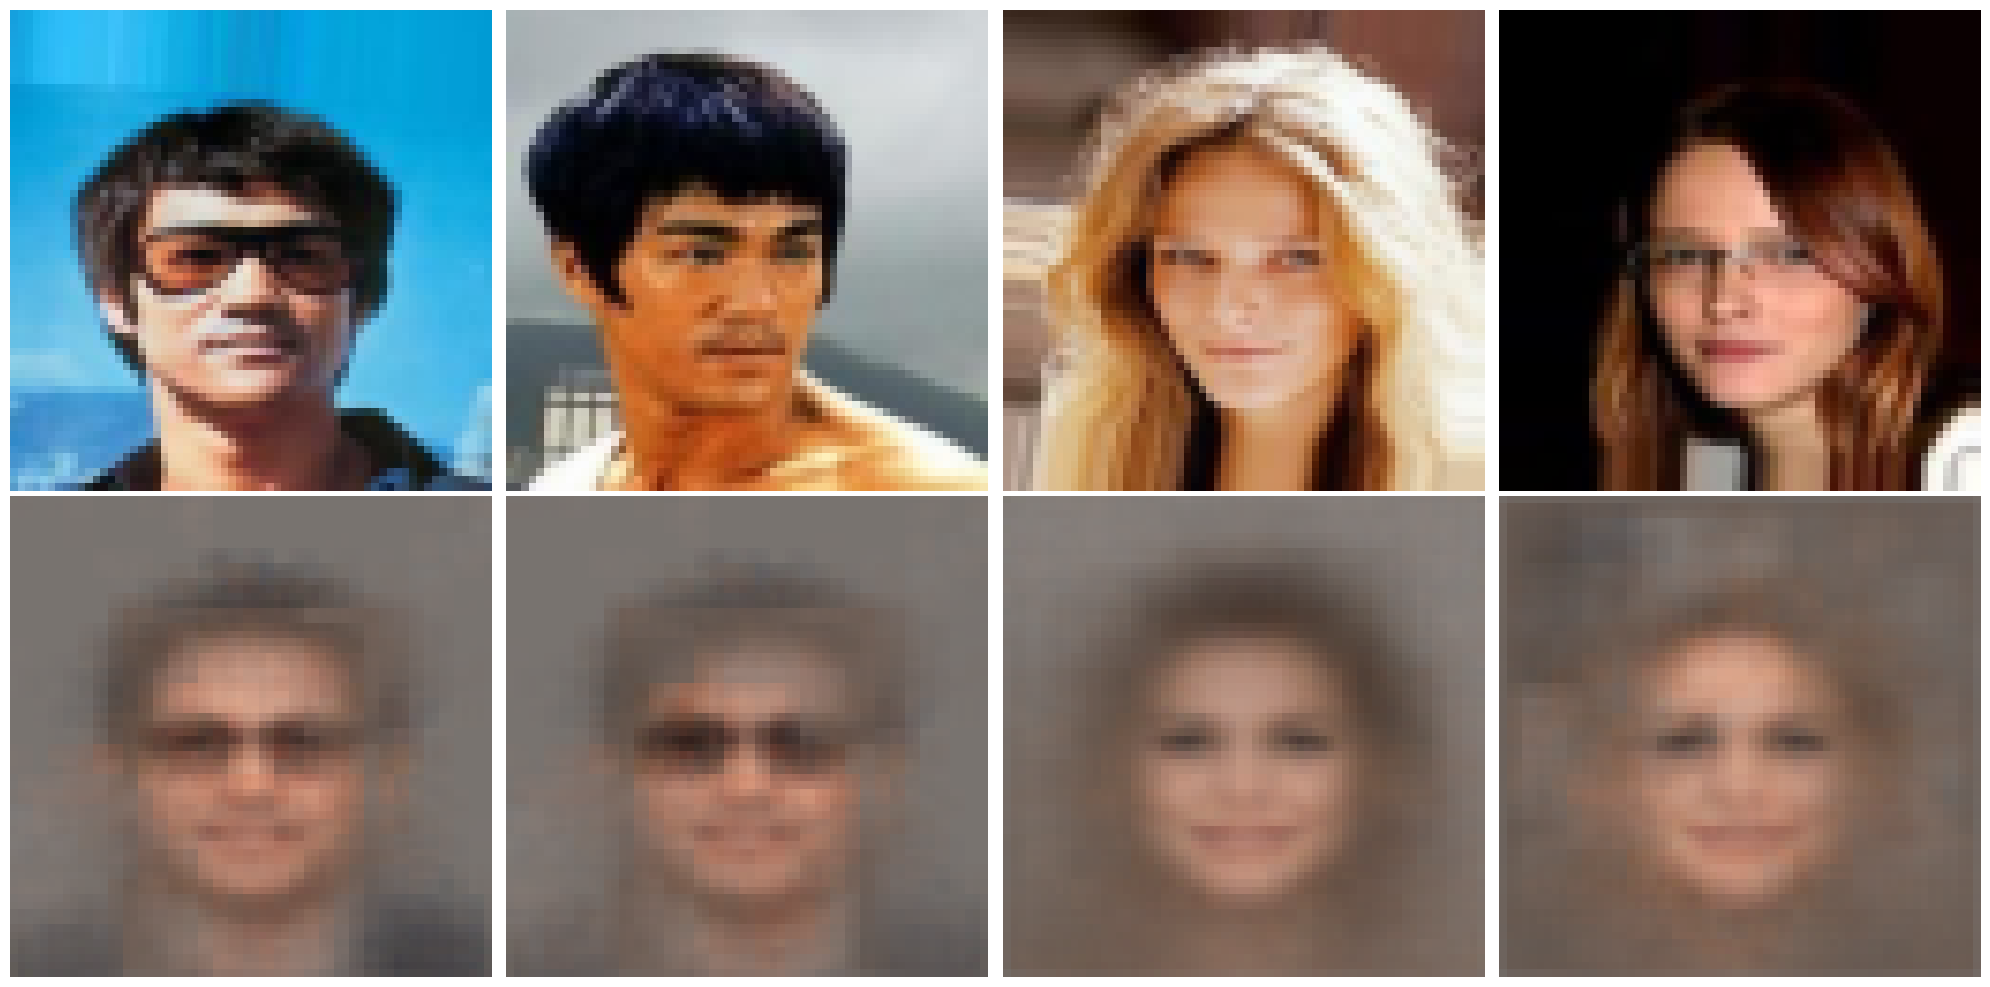

In [322]:
unique_ids, counts = np.unique(train_ds['id'], return_counts=True)
repeated_ids = unique_ids[counts > 1]

chosen_ids = np.random.choice(repeated_ids, 2, replace=False)
chosen = np.concatenate([np.where(train_ds['id'] == chosen_id)[0] for chosen_id in [1407,1575]])

image = train_ds['image'][chosen]
model = hybrid_autoencoder.AutoEncoder()
encoded_image = state_triplet.apply_fn({'params': state_triplet.params}, image, method=model.encode)
decoded_image = state_triplet.apply_fn({'params': state_triplet.params}, encoded_image, method=model.decode)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))  

for idx, i in enumerate(chosen):
    original_image = jax.device_get(image)[idx]
    reconstructed_image = jax.device_get(decoded_image)[idx]

    images = [original_image, reconstructed_image]
    row = 0
    for img in images:
        axs[row][idx].imshow(img)  
        axs[row][idx].axis('off') 
        row += 1

plt.tight_layout() 
plt.show()

In [323]:
# Save regression targets to avoid re-training autoencoder
train_targets = state_triplet.apply_fn({'params': state_triplet.params}, train_ds['image'], method=model.encode)
with open('data/regression/train_targets.pkl', 'wb') as f:
    pickle.dump(train_targets, f)

test1_targets = state_triplet.apply_fn({'params': state_triplet.params}, test1_ds['image'], method=model.encode)
with open('data/regression/test1_targets.pkl', 'wb') as f:
    pickle.dump(test1_targets, f)

test2_targets = state_triplet.apply_fn({'params': state_triplet.params}, test2_ds['image'], method=model.encode)
with open('data/regression/test2_targets.pkl', 'wb') as f:
    pickle.dump(test2_targets, f)

### Pooled Estimator

In [31]:
# In case of a restart of notebook, re-run cells marked: "In case of re-start, run this cell"
with open('data/regression/train_targets.pkl', 'rb') as f:
    train_targets = pickle.load(f)

with open('data/regression/test1_targets.pkl', 'rb') as f:
    test1_targets = pickle.load(f)

with open('data/regression/test2_targets.pkl', 'rb') as f:
    test2_targets = pickle.load(f)

train_ds['label'] = train_targets
test1_ds['label'] = test1_targets
test2_ds['label'] = test2_targets

In [9]:
# Pooled Estimator
config = configs.celebA_experiment()
config.lambda_core = 0.0

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/pooled", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3672, test1_loss: 65061.6289, test2_loss: 60423.5625, core_penalty: 0.0003, val_loss: N/A, ids_more_than_once: 2.14
INFO:absl:epoch: 2, train_loss: 63175.3555, test1_loss: 64699.5547, test2_loss: 60030.1797, core_penalty: 0.0890, val_loss: N/A, ids_more_than_once: 2.71
INFO:absl:epoch: 3, train_loss: 62117.5000, test1_loss: 63766.6562, test2_loss: 59672.7578, core_penalty: 28.8926, val_loss: N/A, ids_more_than_once: 2.36
INFO:absl:epoch: 4, train_loss: 60134.5352, test1_loss: 57254.2188, test2_loss: 61427.5742, core_penalty: 248.0518, val_loss: N/A, ids_more_than_once: 2.57
INFO:absl:epoch: 5, train_loss: 49503.8828, test1_loss: 44233.5977, test2_loss: 73945.9453, core_penalty: 3445.3755, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 6, train_loss: 39252.8828, test1_loss: 32204.5723, test2_loss: 95817.3438, core_penalty: 10403.8853, val_loss: N/A, ids_more_than_once: 2.71
INFO:absl:epoch: 7, train_loss: 30928.9590, test1_loss: 26776.3730

### CoRe estimator
First modify IDs to reflect ID-bin(Y)

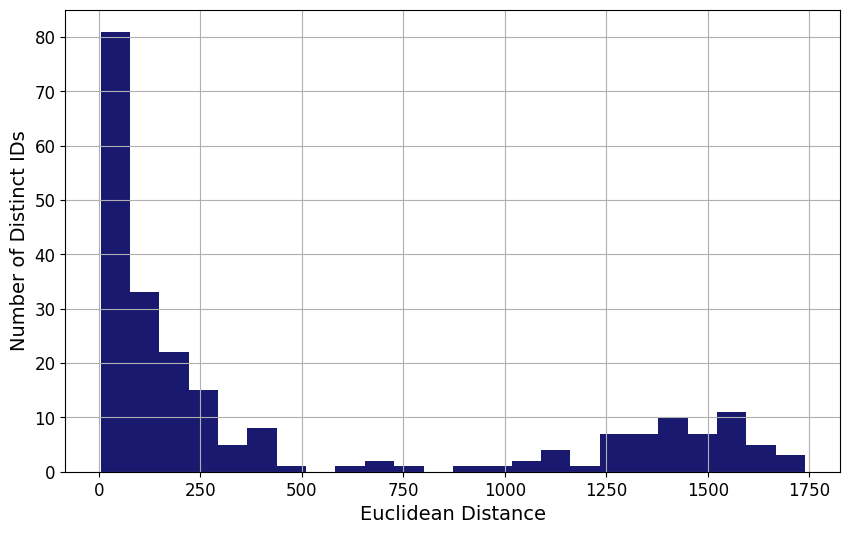

Mean distance: 462.62
Median distance: 150.35


In [35]:
latents =  np.array(train_targets.block_until_ready())
ids = np.array(train_ds['id'])

id_to_latents = {}
for latent, id in zip(latents, ids):
    if id in id_to_latents:
        id_to_latents[id].append(latent)
    else:
        id_to_latents[id] = [latent]

distances = []
for id, latent_list in id_to_latents.items():
    if len(latent_list) == 2: 
        dist = np.sqrt(np.sum((latent_list[0] - latent_list[1]) ** 2))
        distances.append(dist)

# Bin the distances
bins = np.linspace(min(distances), max(distances), num=25)
hist, bin_edges = np.histogram(distances, bins=bins)

plt.figure(figsize=(10, 6)) 
plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, hist, align='center', width=np.diff(bin_edges), color='midnightblue')
plt.xlabel('Euclidean Distance', fontsize=14)  
plt.ylabel('Number of Distinct IDs', fontsize=14)
# plt.title('Histogram of Euclidean Distances Between Latents', fontsize=16) 
plt.grid(True) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

mean_distance = np.mean(distances)
median_distance = np.median(distances)
print(f"Mean distance: {mean_distance:.2f}")
print(f"Median distance: {median_distance:.2f}")

In [15]:
max_id = train_ds['id'].max()
ID_array = np.array(train_ds['id'].block_until_ready())
for id, latent_list in id_to_latents.items():
    if len(latent_list) == 2: 
        dist = np.sqrt(np.sum((latent_list[0] - latent_list[1]) ** 2))
        if dist > median:
            # find indices of these two images
            img_idx = np.where(train_ds['id'] == id)[0]
            second_idx = img_idx[1]
            # give new ID
            ID_array[second_idx] = max_id + 1
            max_id += 1

train_ds['id'] = jnp.array(ID_array)

In [16]:
# CoRe Estimator
config = configs.celebA_experiment()
config.lambda_core = 10.0

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/CoRe", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3672, test1_loss: 65061.6289, test2_loss: 60423.5625, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 0.86
INFO:absl:epoch: 2, train_loss: 63175.4453, test1_loss: 64699.3008, test2_loss: 60030.1016, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 3, train_loss: 62307.5586, test1_loss: 63783.5078, test2_loss: 59457.4219, core_penalty: 10.0264, val_loss: N/A, ids_more_than_once: 1.36
INFO:absl:epoch: 4, train_loss: 61905.6016, test1_loss: 62685.0195, test2_loss: 60571.7148, core_penalty: 56.8261, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 5, train_loss: 59139.6758, test1_loss: 56423.2227, test2_loss: 63079.9023, core_penalty: 220.8118, val_loss: N/A, ids_more_than_once: 0.43
INFO:absl:epoch: 6, train_loss: 59727.2109, test1_loss: 61010.9805, test2_loss: 61166.8750, core_penalty: 517.9661, val_loss: N/A, ids_more_than_once: 1.57
INFO:absl:epoch: 7, train_loss: 58501.0703, test1_loss: 55628.6172, te

In [17]:
# CoRe Estimator
config = configs.celebA_experiment()
config.lambda_core = 100.0

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/CoRe", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3945, test1_loss: 65061.6797, test2_loss: 60423.6172, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 0.86
INFO:absl:epoch: 2, train_loss: 63176.6680, test1_loss: 64701.7656, test2_loss: 60034.5586, core_penalty: 0.0094, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 3, train_loss: 62999.5938, test1_loss: 64126.0312, test2_loss: 59650.0664, core_penalty: 1.4987, val_loss: N/A, ids_more_than_once: 1.36
INFO:absl:epoch: 4, train_loss: 63341.3086, test1_loss: 64590.3203, test2_loss: 60414.1914, core_penalty: 10.2105, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 5, train_loss: 62738.9453, test1_loss: 63890.9414, test2_loss: 60183.9922, core_penalty: 0.2409, val_loss: N/A, ids_more_than_once: 0.43
INFO:absl:epoch: 6, train_loss: 62707.2383, test1_loss: 64029.7461, test2_loss: 60267.9805, core_penalty: 8.9784, val_loss: N/A, ids_more_than_once: 1.57
INFO:absl:epoch: 7, train_loss: 62150.1680, test1_loss: 62191.4297, test2_l

In [18]:
# CoRe Estimator
config = configs.celebA_experiment()
config.lambda_core = 1.0

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/CoRe", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3672, test1_loss: 65061.6289, test2_loss: 60423.5625, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 0.86
INFO:absl:epoch: 2, train_loss: 63175.3555, test1_loss: 64699.4609, test2_loss: 60030.1250, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 3, train_loss: 62134.8164, test1_loss: 63779.7422, test2_loss: 59660.5586, core_penalty: 14.0695, val_loss: N/A, ids_more_than_once: 1.36
INFO:absl:epoch: 4, train_loss: 60559.0234, test1_loss: 58067.8359, test2_loss: 60811.1016, core_penalty: 262.7604, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 5, train_loss: 52720.6484, test1_loss: 49936.6836, test2_loss: 67026.0078, core_penalty: 2289.7535, val_loss: N/A, ids_more_than_once: 0.43
INFO:absl:epoch: 6, train_loss: 48604.3555, test1_loss: 43530.9258, test2_loss: 72183.2656, core_penalty: 3761.0479, val_loss: N/A, ids_more_than_once: 1.57
INFO:absl:epoch: 7, train_loss: 43414.0938, test1_loss: 42013.5703,

In [19]:
# CoRe Estimator
config = configs.celebA_experiment()
config.lambda_core = 0.1

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/CoRe", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3672, test1_loss: 65061.6289, test2_loss: 60423.5625, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 0.86
INFO:absl:epoch: 2, train_loss: 63175.3633, test1_loss: 64699.5234, test2_loss: 60030.1484, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 3, train_loss: 62119.0742, test1_loss: 63766.4492, test2_loss: 59670.2852, core_penalty: 14.4720, val_loss: N/A, ids_more_than_once: 1.36
INFO:absl:epoch: 4, train_loss: 60178.8086, test1_loss: 57300.5625, test2_loss: 61355.1602, core_penalty: 349.2584, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 5, train_loss: 49825.1992, test1_loss: 45259.8945, test2_loss: 72456.4531, core_penalty: 2180.2592, val_loss: N/A, ids_more_than_once: 0.43
INFO:absl:epoch: 6, train_loss: 40629.3867, test1_loss: 33248.7188, test2_loss: 97154.2734, core_penalty: 6800.0751, val_loss: N/A, ids_more_than_once: 1.57
INFO:absl:epoch: 7, train_loss: 32740.4688, test1_loss: 29675.7246,

In [20]:
# CoRe Estimator
config = configs.celebA_experiment()
config.lambda_core = 0.01

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/CoRe", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3672, test1_loss: 65061.6289, test2_loss: 60423.5625, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 0.86
INFO:absl:epoch: 2, train_loss: 63175.3516, test1_loss: 64699.3945, test2_loss: 60030.1797, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 3, train_loss: 62117.1367, test1_loss: 63763.5859, test2_loss: 59672.3984, core_penalty: 14.5040, val_loss: N/A, ids_more_than_once: 1.36
INFO:absl:epoch: 4, train_loss: 60130.5273, test1_loss: 57237.5625, test2_loss: 61432.6797, core_penalty: 360.1750, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 5, train_loss: 49528.8086, test1_loss: 44323.4883, test2_loss: 73811.2188, core_penalty: 2151.5329, val_loss: N/A, ids_more_than_once: 0.43
INFO:absl:epoch: 6, train_loss: 39397.8672, test1_loss: 32265.3184, test2_loss: 96464.9609, core_penalty: 7432.1708, val_loss: N/A, ids_more_than_once: 1.57
INFO:absl:epoch: 7, train_loss: 31128.8086, test1_loss: 27251.7168,

In [21]:
# CoRe Estimator
config = configs.celebA_experiment()
config.lambda_core = 1.0
config.no_cfl_frac = 0.1
config.cfl_anneal = True

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/CoRe", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3672, test1_loss: 65061.6289, test2_loss: 60423.5625, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 0.86
INFO:absl:epoch: 2, train_loss: 63175.3555, test1_loss: 64699.5547, test2_loss: 60030.1797, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 3, train_loss: 62117.5000, test1_loss: 63766.6562, test2_loss: 59672.7578, core_penalty: 14.5177, val_loss: N/A, ids_more_than_once: 1.36
INFO:absl:epoch: 4, train_loss: 60134.5352, test1_loss: 57254.2188, test2_loss: 61427.5742, core_penalty: 358.0784, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 5, train_loss: 49621.0312, test1_loss: 44600.0859, test2_loss: 73354.9297, core_penalty: 2135.7183, val_loss: N/A, ids_more_than_once: 0.43
INFO:absl:epoch: 6, train_loss: 40119.6758, test1_loss: 32548.5449, test2_loss: 97974.5312, core_penalty: 6904.7692, val_loss: N/A, ids_more_than_once: 1.57
INFO:absl:epoch: 7, train_loss: 32675.7246, test1_loss: 29802.8887,

In [22]:
# CoRe Estimator
config = configs.celebA_experiment()
config.lambda_core = 0.1
config.no_cfl_frac = 0.1
config.cfl_anneal = True

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/CoRe", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3672, test1_loss: 65061.6289, test2_loss: 60423.5625, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 0.86
INFO:absl:epoch: 2, train_loss: 63175.3555, test1_loss: 64699.5547, test2_loss: 60030.1797, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 3, train_loss: 62117.5000, test1_loss: 63766.6562, test2_loss: 59672.7578, core_penalty: 14.5177, val_loss: N/A, ids_more_than_once: 1.36
INFO:absl:epoch: 4, train_loss: 60134.5352, test1_loss: 57254.2188, test2_loss: 61427.5742, core_penalty: 358.0784, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 5, train_loss: 49515.3438, test1_loss: 44269.1562, test2_loss: 73888.5547, core_penalty: 2139.8995, val_loss: N/A, ids_more_than_once: 0.43
INFO:absl:epoch: 6, train_loss: 39337.5117, test1_loss: 32213.1523, test2_loss: 96343.0703, core_penalty: 7464.3388, val_loss: N/A, ids_more_than_once: 1.57
INFO:absl:epoch: 7, train_loss: 31098.6406, test1_loss: 27083.5645,

In [23]:
# CoRe Estimator
config = configs.celebA_experiment()
config.lambda_core = 10.0
config.no_cfl_frac = 0.1
config.cfl_anneal = True

config.batch_size = 256
config.num_epochs = 30

steps_per_epoch = config.train_size // config.batch_size
config.warmup_steps = steps_per_epoch * int(0.1 * config.num_epochs)
config.decay_steps = steps_per_epoch
config.decay_rate = 0.95
config.learning_rate = 1e-3

config.lambda_l2 = 1e-2

config.model = 'regression'
_ = train.train_and_evaluate(config, workdir=f"models_celebA/CoRe", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 63418.3672, test1_loss: 65061.6289, test2_loss: 60423.5625, core_penalty: 0.0002, val_loss: N/A, ids_more_than_once: 0.86
INFO:absl:epoch: 2, train_loss: 63175.3555, test1_loss: 64699.5547, test2_loss: 60030.1797, core_penalty: 0.0095, val_loss: N/A, ids_more_than_once: 1.14
INFO:absl:epoch: 3, train_loss: 62117.5000, test1_loss: 63766.6562, test2_loss: 59672.7578, core_penalty: 14.5177, val_loss: N/A, ids_more_than_once: 1.36
INFO:absl:epoch: 4, train_loss: 60134.5352, test1_loss: 57254.2188, test2_loss: 61427.5742, core_penalty: 358.0784, val_loss: N/A, ids_more_than_once: 1.29
INFO:absl:epoch: 5, train_loss: 50694.5039, test1_loss: 48214.9141, test2_loss: 68898.4531, core_penalty: 2118.6088, val_loss: N/A, ids_more_than_once: 0.43
INFO:absl:epoch: 6, train_loss: 47468.6992, test1_loss: 44739.3828, test2_loss: 69633.4219, core_penalty: 4740.0039, val_loss: N/A, ids_more_than_once: 1.57
INFO:absl:epoch: 7, train_loss: 43539.3555, test1_loss: 42916.5078,